In [1]:
import os
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
from PIL import Image
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Dataset

C:\Users\USER\anaconda3\envs\preparation\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = os.getcwd()
save_path = os.path.join(path,"save")

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(1016) # Seed 고정

In [4]:
# 데이터 로딩 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): csv 파일의 경로.
            transform (callable, optional): 샘플에 적용될 Optional transform.
        """
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df['img_path'].iloc[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 이미지 전처리 및 임베딩
transform_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
#     transforms.RandomGrayscale(p=0.25),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
transform_test = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])
train_data = CustomDataset(csv_file=os.path.join(path,"train.csv"), transform=transform_train)
train_loader = DataLoader(train_data, batch_size=8, shuffle=False)

In [6]:
# CNN 기반 Autoencoder 모델 정의
class AutoencoderCNN(nn.Module):
    def __init__(self):
        super(AutoencoderCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.8),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ELU(0.8),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.8),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ELU(0.8),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ELU(0.8),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ELU(0.8),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ELU(0.8),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.8),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ELU(0.8),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
model = AutoencoderCNN().to(device)
print(model)
# 손실 함수 및 최적화 기준 설정
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
# 모델 학습
num_epochs = 500
for epoch in range(num_epochs):
    running_loss = 0.0
    for data in train_loader:
        images = data
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader.dataset)}")

AutoencoderCNN(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.8)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ELU(alpha=0.8)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.8)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ELU(alpha=0.8)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): ELU(alpha=0.8)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ELU(alpha=0.8)
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ELU(alpha=0.8)
    (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): LeakyReLU(negative_slo

Epoch [159/500], Loss: 0.0005289167086506358
Epoch [160/500], Loss: 0.0005423778543978964
Epoch [161/500], Loss: 0.0005647634806990308
Epoch [162/500], Loss: 0.0006006902535752056
Epoch [163/500], Loss: 0.0006670118850642736
Epoch [164/500], Loss: 0.0007556591288431464
Epoch [165/500], Loss: 0.0008089706116408425
Epoch [166/500], Loss: 0.0008195682194853472
Epoch [167/500], Loss: 0.000753067566645922
Epoch [168/500], Loss: 0.0006452923350390309
Epoch [169/500], Loss: 0.0005844860789125584
Epoch [170/500], Loss: 0.0005523276798418361
Epoch [171/500], Loss: 0.0005430240422364831
Epoch [172/500], Loss: 0.0005437673365767223
Epoch [173/500], Loss: 0.0005540416623518186
Epoch [174/500], Loss: 0.0005722689082159578
Epoch [175/500], Loss: 0.0006054149658589716
Epoch [176/500], Loss: 0.0006615481743296092
Epoch [177/500], Loss: 0.0007441882533239892
Epoch [178/500], Loss: 0.0008077589727221101
Epoch [179/500], Loss: 0.0008356946005656476
Epoch [180/500], Loss: 0.0009151470780202096
Epoch [181/

Epoch [342/500], Loss: 0.00038582927048940894
Epoch [343/500], Loss: 0.0003899536281386871
Epoch [344/500], Loss: 0.0004000313519369024
Epoch [345/500], Loss: 0.0004186116228920753
Epoch [346/500], Loss: 0.0004502560091019114
Epoch [347/500], Loss: 0.0004443029714300092
Epoch [348/500], Loss: 0.0004543745228933267
Epoch [349/500], Loss: 0.0004694730243175575
Epoch [350/500], Loss: 0.00048025648799361967
Epoch [351/500], Loss: 0.0005004198902271286
Epoch [352/500], Loss: 0.0005167149740518311
Epoch [353/500], Loss: 0.0005449766053778815
Epoch [354/500], Loss: 0.0005607620589959789
Epoch [355/500], Loss: 0.0005779678631626385
Epoch [356/500], Loss: 0.0005378045476186024
Epoch [357/500], Loss: 0.0005290241291125616
Epoch [358/500], Loss: 0.0005299642454163814
Epoch [359/500], Loss: 0.0005217726086047718
Epoch [360/500], Loss: 0.0005141916223517466
Epoch [361/500], Loss: 0.0005064260593326894
Epoch [362/500], Loss: 0.0004960187592493379
Epoch [363/500], Loss: 0.0004878481267951429
Epoch [3

In [8]:
train_loss = running_loss/len(train_loader.dataset)
print(train_loss)

0.0005063624689661561


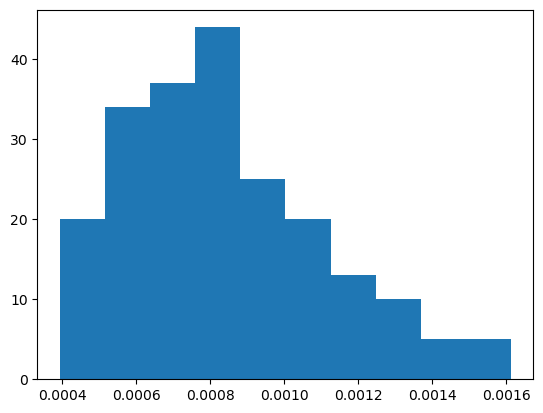

0.0008379676762668792
0.001613063272088766


In [14]:
train_dataset2 = CustomDataset(csv_file=os.path.join(path,"train.csv"), transform=transform_test)
train_loader2 = DataLoader(train_dataset2, shuffle=False)

correct = 0
total = 0
test_pred = []
loss_list = []
with torch.no_grad():
    for data in train_loader2:
        images = data
        images = images.to(device)
        outputs = model(images)
        loss = criterion(outputs, images).to(device).item()
        loss_list.append(loss)
# print(loss_list)
plt.hist(loss_list)
plt.show()
print(np.mean(loss_list))
m1 = np.percentile(np.array(loss_list), 100, axis=0)
print(m1)
            

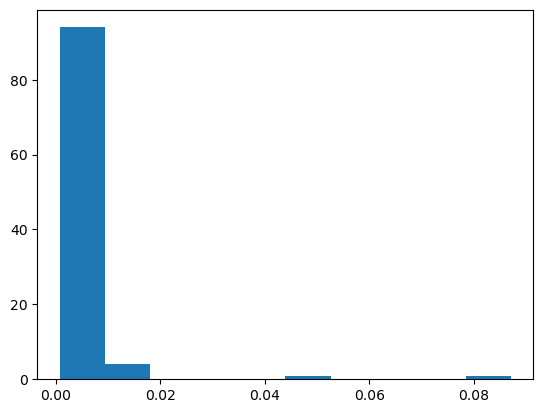

In [15]:
test_dataset = CustomDataset(csv_file=os.path.join(path,"test.csv"), transform=transform_test)
test_loader = DataLoader(test_dataset, shuffle=False)

correct = 0
total = 0
test_pred = []
loss_list = []
with torch.no_grad():
    for data in test_loader:
        images = data
        images = images.to(device)
        outputs = model(images)
        loss = criterion(outputs, images).to(device).item()
        loss_list.append(loss)
        if loss<=m1 :#or loss>=m2:
            test_pred.append(0.)
        else:
            test_pred.append(1.)
plt.hist(loss_list)
plt.show()            

Text(50.722222222222214, 0.5, 'True Label')

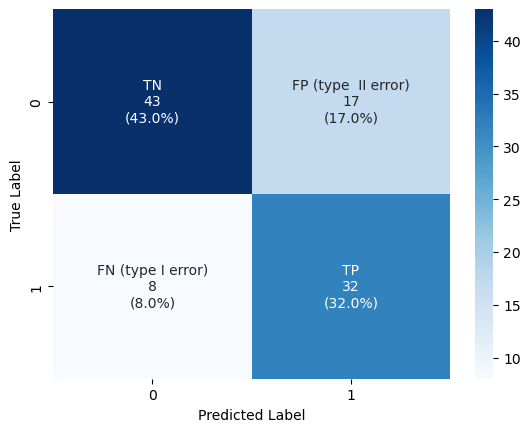

In [16]:
answer = [0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,1,1,1,0,1,0,0,1,1,1,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,1,1,1,1,1,0,0,1,1]
cf_matrix = confusion_matrix(answer, test_pred)
group_names = ["TN", "FP (type  II error)", "FN (type I error)", "TP"]
group_counts = [value for value in cf_matrix.flatten()]
group_percentages = [f"{value:.1%}" for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n({v3})" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
labels
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [17]:
submit = pd.read_csv(os.path.join(path,"sample_submission.csv"))
submit['label'] = test_pred
submit.head()

,id,label
0,TEST_000,1.0
1,TEST_001,1.0
2,TEST_002,0.0
3,TEST_003,1.0
4,TEST_004,0.0


In [18]:
submit.to_csv(os.path.join(save_path,"submit81.csv"), index=False)